<a href="https://colab.research.google.com/github/sheemambabu/CMPE-258-Deep-Learning/blob/main/Assignment%206/Assignment_6_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CMPE-258 Deep Learning**

## Assignment 6 Part A 

## By: Sheema Murugesh Babu (SJSU_ID: 015217176)

# Part A:  Implementing autograd framework in python and numpy and MNIST classifier using the autograd framework.

## Importing all the necessary libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils import np_utils
from scipy.special import softmax

np.random.seed(0)

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Tensor:

  def __init__(self, data, requires_grad=False):
      self.data = data
      if not isinstance(data, np.ndarray):
          self.data = np.array(data)
      self.requires_grad = requires_grad
      self._grad = None
      self._grad_fn = None

  @property
  def shape(self):
      return self.data.shape

  @property
  def grad_fn(self):
      if not self.requires_grad:
          raise Exception('This tensor is not backpropagated')
      return self._grad_fn

  @property
  def grad(self):
      return self._grad

  def backward(self, grad=None):
      if not self.grad_fn:
          return False

      if grad is None and self._grad is None:
          grad = self.__class__(1., requires_grad=False)

      elif self.grad is not None:
          grad = self._grad

      if not self.requires_grad:
          raise Exception('This tensor is not backpropagated')

      self.grad_fn.backward(grad)
      return True

  def __str__(self):
      return f'Tensor({str(self.data)})'

  def add_grad(self, grad):
      if self._grad is None:
          self._grad = grad
      else:
          self._grad += grad

  def __add__(self, o): 
      if self.data is not None:
          self.data += o.data  
          return self
      self.data = o.data 
      return self

class Operation:

  def forward(self):
      raise NotImplemented

  def backward(self, grad):
      raise NotImplemented

  def __call__(self, *args):
      self.out = self.forward(*args)
      self.out._grad_fn = self
      return self.out


class AddOp(Operation):

  def forward(self, x: Tensor, y: Tensor):
      self.x = x
      self.y = y
      requires_grad = x.requires_grad or y.requires_grad
      return Tensor(x.data + y.data, requires_grad=requires_grad)

  def backward(self, grad):
      if self.x.requires_grad:

          if self.x.shape != grad.shape:
              axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
              self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
          else:
              self.x.add_grad(grad)
          if self.x.grad_fn:
              self.x.backward()
      if self.y.requires_grad:
          if self.y.shape != grad.shape:
              axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
              self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
          else:
              self.y.add_grad(grad)
          if self.y.grad_fn:
              self.y.backward()


class MulOp(Operation):

  def forward(self, x: Tensor, y: Tensor):
      self.x = x
      self.y = y
      requires_grad = x.requires_grad or y.requires_grad
      return Tensor(x.data * y.data, requires_grad=requires_grad)

  def backward(self, grad):
      if self.x.requires_grad:
          self.x.add_grad(Tensor(grad.data * self.y.data, False))
          if self.x.grad_fn:
              self.x.backward()
      if self.y.requires_grad:
          self.y.add_grad(Tensor(grad.data * self.x.data, False))
          if self.y.grad_fn:
              self.y.backward()

## Building a nueral network with autograd and activation function

In [ ]:
class Layer:

    def forward(self):
        raise NotImplemented
    
    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
      
    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)
        
        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

In [ ]:
class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad

In [ ]:
simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')

4.726924922060479
---------
inf
---------
164.19280936343645
---------
170.23764014738856
---------
158.15323969375288
---------
144.90045095674787
---------
143.31718820919335
---------
140.38025325174763
---------
141.31291752011754
---------
133.45790639441492
---------
132.21741740772097
---------
122.69475299410996
---------
123.62616695830722
---------
126.06509766352727
---------
114.63053913631957
---------
111.38351796251999
---------
104.22947821825764
---------
102.23743642080971
---------
103.54262589884588
---------
102.0173078067015
---------
90.05735082262456
---------
107.8322196460996
---------
95.36223463822344
---------
91.1986350286669
---------
95.83974355846671
---------
93.16385342502217
---------
89.15477938946691
---------
90.77834677555146
---------
86.91787963306788
---------
91.97345399900556
---------
75.43006758195719
---------
73.6805993060507
---------
75.2952704069972
---------
72.6275968356876
---------
74.90823265447789
---------
84.05855052533767
---

## For MNIST data

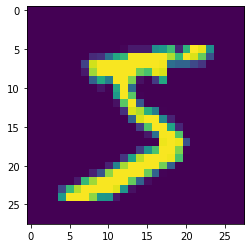

target: 5 predicted: 5


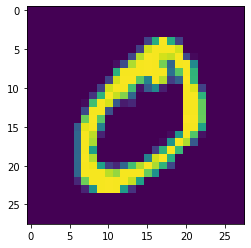

target: 0 predicted: 0


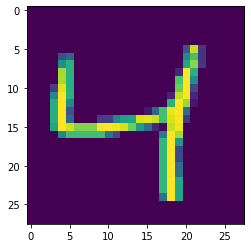

target: 4 predicted: 4


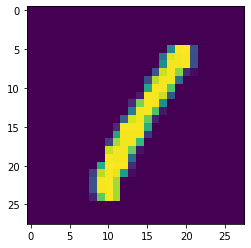

target: 1 predicted: 1


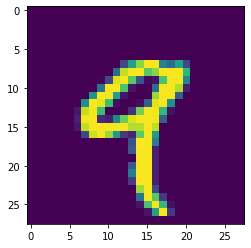

target: 9 predicted: 9


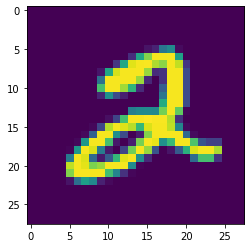

target: 2 predicted: 2


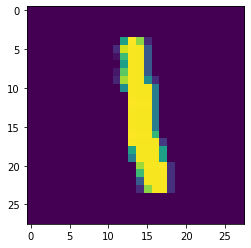

target: 1 predicted: 1


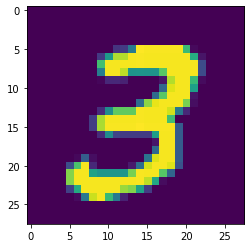

target: 3 predicted: 3


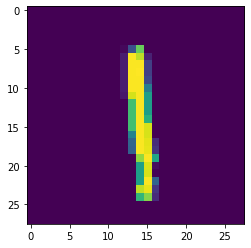

target: 1 predicted: 1


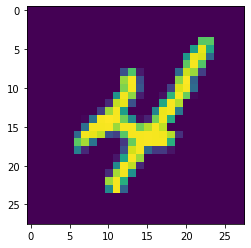

target: 4 predicted: 4


In [ ]:
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )

# References

1) https://github.com/iamtrask/Grokking-Deep-Learning/blob/master/Chapter13%20-%20Intro%20to%20Automatic%20Differentiation%20-%20Let's%20Build%20A%20Deep%20Learning%20Framework.ipynb <br></br>

2) https://colab.research.google.com/drive/1kewjqN5LUZI7z5KNMxt3BV8lzEmCsbNf#scrollTo=qr_GIWWLoBkd <br></br>